# Modèle linéaire de prédiction

### Librairies

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from datetime import datetime

from lib.dataeng import Etl

import seaborn as sns

from tqdm import tqdm

from pprint import pprint

2024-03-10 10:35:56.718522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Sourcing Data

In [2]:
etl = Etl()

df_weight_raw, df_food_raw, df_exos_raw, df_all = etl.extract_store_all()


Le fichier poids le plus récent est : data_BEN_1710062369.zip, parmi :
data_BEN_1709618939.zip
data_BEN_1710062369.zip
data_BEN_1709706688.zip
data_BEN_1709793066.zip
data_BEN_1709967514.zip
data_BEN_1709531484.zip
data_BEN_1709877373.zip

Le fichier food le plus récent est : File-Export-2020-08-03-to-2024-03-10.zip, parmi
File-Export-2020-08-03-to-2024-03-07.zip
File-Export-2020-08-03-to-2024-03-08.zip
File-Export-2020-08-03-to-2024-03-04.zip
File-Export-2020-08-03-to-2024-03-05.zip
File-Export-2020-08-03-to-2024-03-10.zip
File-Export-2020-08-03-to-2024-03-06.zip
File-Export-2020-08-03-to-2024-03-09.zip

Le fichier exercices le plus récent est : polar-user-data-export_bd8a06c1-7cac-47fc-a1fe-71b374e61732.zip, parmi :
polar-user-data-export_bd8a06c1-7cac-47fc-a1fe-71b374e61732.zip
polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip


100%|██████████| 1924/1924 [01:15<00:00, 25.63it/s]


## Constitution Dataset

### Poids

In [3]:
df_weight_raw

,Date,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
0,2024-03-10,72.70,11.45,3.07,58.17,41.47,0.157497,1693.000
1,2024-03-10,72.46,11.38,3.06,58.00,41.32,0.157052,1689.328
2,2024-03-10,72.66,11.45,3.07,58.13,41.43,0.157583,1692.136
3,2024-03-10,72.64,11.49,3.06,58.07,41.36,0.158177,1690.840
4,2024-03-10,72.69,11.49,3.07,58.11,41.40,0.158069,1691.920
...,...,...,...,...,...,...,...,...
9545,2020-08-14,104.50,33.85,NaN,NaN,NaN,0.323923,1896.040
9546,2020-08-13,104.40,34.34,NaN,NaN,NaN,0.328927,1883.296
9547,2020-08-12,104.35,33.80,NaN,NaN,NaN,0.323910,1893.880
9548,2020-08-11,104.65,33.15,NaN,NaN,NaN,0.316770,1914.400


In [4]:
df_weight = df_weight_raw.groupby('Date').mean()  # récupère les valeurs quotidiennes moyennes

std_empiriques = df_weight_raw.groupby('Date').std().dropna()  # calcule les ecarts-types empiriques

In [5]:
df_weight_raw.groupby('Date').std().describe(include='all')

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
count,1264.000000,1264.000000,371.000000,371.000000,371.000000,1264.000000,1264.000000
mean,0.070822,0.086763,0.004791,0.068577,0.076705,0.001066,1.728919
std,0.046477,0.076898,0.003592,0.039513,0.057401,0.000779,1.660962
min,0.000000,0.000000,0.000000,0.009910,0.013887,0.000054,0.000000
25%,0.038397,0.054887,0.003836,0.053175,0.057467,0.000722,1.111928
50%,0.057009,0.075024,0.004880,0.067338,0.072019,0.000963,1.449125
75%,0.096845,0.096458,0.005345,0.079666,0.086846,0.001216,1.867806
max,0.588509,1.139576,0.063631,0.716210,1.072184,0.011172,24.415008


In [6]:
std_empiriques

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-03-04,0.036148,0.058992,0.004082,0.056716,0.066533,0.000812,1.264415
2023-03-05,0.092376,0.106369,0.000000,0.037353,0.053229,0.001281,0.821828
2023-03-06,0.023452,0.030496,0.000000,0.031937,0.040988,0.000427,0.787734
2023-03-07,0.018708,0.050067,0.000000,0.052026,0.072019,0.000706,1.255156
2023-03-08,0.042269,0.052313,0.004082,0.038297,0.064317,0.000674,0.893206
...,...,...,...,...,...,...,...
2024-03-06,0.103703,0.096791,0.005606,0.088479,0.101339,0.001226,1.995100
2024-03-07,0.094163,0.081696,0.006325,0.086806,0.102432,0.001059,1.960841
2024-03-08,0.127212,0.101817,0.007188,0.103905,0.124766,0.001277,2.353599


In [7]:
std_empiriques.describe(include='all')

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
count,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000
mean,0.102701,0.086265,0.004791,0.068577,0.076705,0.001036,1.568373
std,0.056497,0.028280,0.003592,0.039513,0.057401,0.000337,0.921199
min,0.011127,0.021931,0.000000,0.009910,0.013887,0.000292,0.282810
25%,0.051972,0.065267,0.003836,0.053175,0.057467,0.000810,1.211289
50%,0.112151,0.087014,0.004880,0.067338,0.072019,0.001033,1.539337
75%,0.136078,0.104428,0.005345,0.079666,0.086846,0.001229,1.825357
max,0.588509,0.195337,0.063631,0.716210,1.072184,0.003612,16.816833


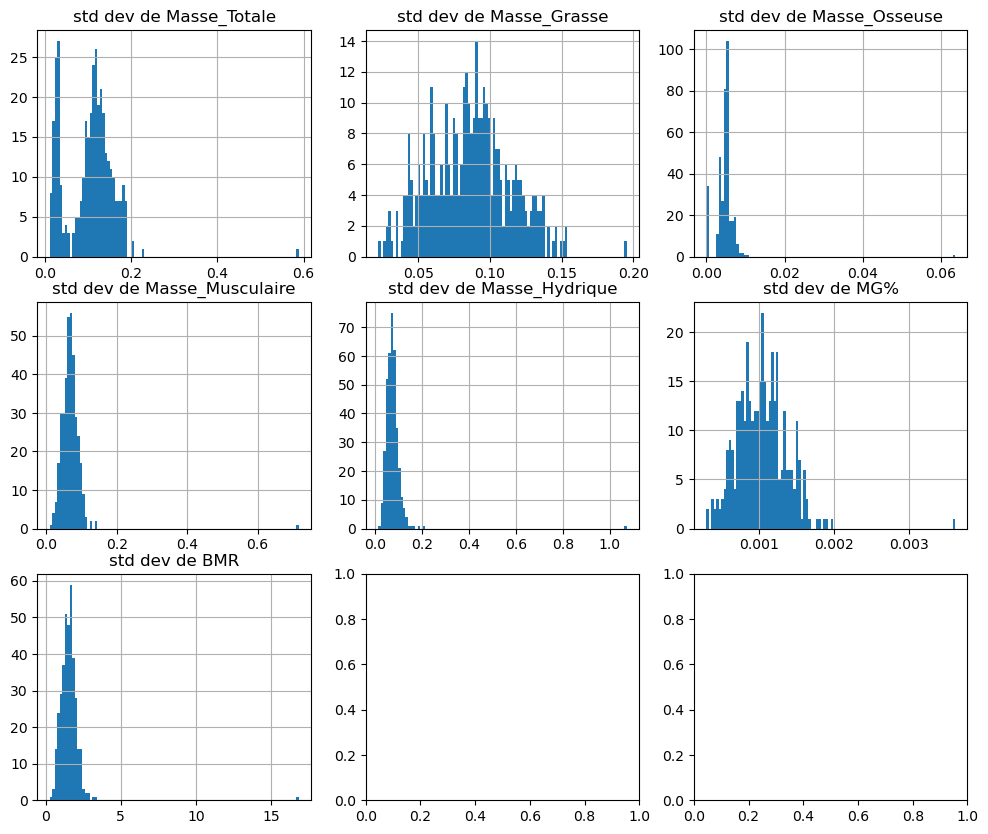

In [8]:
fig, axs = plt.subplots(nrows=len(std_empiriques.columns)//3+1, ncols=3, figsize=(12,10))
NBINS = 100

for i, name in enumerate(std_empiriques.columns):
    r = i//3
    c = i%3
    x = std_empiriques[name].to_numpy()
    axs[r,c].hist(x, bins=NBINS)
    axs[r,c].set_title(f'std dev de {name}')
    axs[r,c].grid(True)

plt.show()

In [9]:
df_weight

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2020-08-09,107.250000,37.190000,NaN,NaN,NaN,0.346760,1883.2960
2020-08-11,104.650000,33.150000,NaN,NaN,NaN,0.316770,1914.4000
2020-08-12,104.350000,33.800000,NaN,NaN,NaN,0.323910,1893.8800
2020-08-13,104.400000,34.340000,NaN,NaN,NaN,0.328927,1883.2960
2020-08-14,104.500000,33.850000,NaN,NaN,NaN,0.323923,1896.0400
...,...,...,...,...,...,...,...
2024-03-06,71.974000,11.616000,3.01800,57.320000,40.545333,0.161391,1673.7328
2024-03-07,71.593333,11.222000,3.02400,57.330667,40.659333,0.156746,1674.0208
2024-03-08,72.173125,11.122500,3.06125,57.973125,41.372500,0.154108,1688.6935


### Food

In [10]:
df_food_raw

,Date,Meal,Calories,Lipides,Glucides,Proteines
0,2020-08-03,Breakfast,621.4,27.9,69.7,22.4
1,2020-08-03,Dinner,581.6,20.4,84.5,17.1
2,2020-08-03,Lunch,656.0,41.4,26.6,33.5
3,2020-08-03,Snacks,58.0,0.0,14.0,0.0
4,2020-08-04,Breakfast,1111.6,49.0,137.8,34.3
...,...,...,...,...,...,...
3811,2024-03-08,Breakfast,1019.9,21.9,87.9,120.6
3812,2024-03-08,Dinner,987.2,10.1,110.0,35.8
3813,2024-03-08,Lunch,1109.2,47.7,134.3,39.7
3814,2024-03-09,Breakfast,1769.0,51.6,165.1,159.0


In [11]:
df_food = df_food_raw.set_index(['Date','Meal']).unstack('Meal')

In [12]:
df_food.fillna(0, inplace=True)

In [13]:
df_food.columns = df_food.columns.to_flat_index()

In [14]:
new_names = [ name[0] + '_' + name[1] for name in df_food.columns ]
df_food.columns = new_names

In [15]:
df_food

,Calories_Breakfast,Calories_Dinner,Calories_Lunch,Calories_Snacks,Lipides_Breakfast,Lipides_Dinner,Lipides_Lunch,Lipides_Snacks,Glucides_Breakfast,Glucides_Dinner,Glucides_Lunch,Glucides_Snacks,Proteines_Breakfast,Proteines_Dinner,Proteines_Lunch,Proteines_Snacks
Date,,,,,,,,,,,,,,,,
2020-08-03,621.4,581.6,656.0,58.0,27.9,20.4,41.4,0.0,69.7,84.5,26.6,14.0,22.4,17.1,33.5,0.0
2020-08-04,1111.6,447.4,433.7,0.0,49.0,2.1,16.6,0.0,137.8,69.1,60.6,0.0,34.3,28.5,15.6,0.0
2020-08-05,1174.2,136.7,638.0,0.0,51.6,6.7,25.8,0.0,147.1,3.2,62.8,0.0,35.7,14.8,36.4,0.0
2020-08-06,747.0,801.3,388.9,0.0,35.3,15.5,15.6,0.0,81.4,22.6,30.3,0.0,25.8,11.8,22.4,0.0
2020-08-07,791.9,397.5,484.6,0.0,35.5,7.2,24.8,0.0,91.6,75.4,1.9,0.0,27.3,7.9,60.0,0.0
2020-08-08,714.5,359.8,499.3,383.1,29.8,19.8,22.7,19.3,85.6,3.4,38.5,1.6,26.4,40.0,26.7,14.7
2020-08-09,683.1,504.7,615.5,58.0,25.0,30.8,15.5,0.0,88.3,51.2,91.5,14.0,26.7,10.6,28.8,0.0
2020-08-10,646.8,604.6,214.0,0.0,21.0,10.0,11.8,0.0,88.3,107.8,11.1,0.0,26.7,20.7,14.9,0.0
2020-08-11,557.5,413.1,801.8,0.0,12.9,21.3,16.3,0.0,83.2,43.4,59.2,0.0,26.8,10.3,67.0,0.0


### Exercices

In [16]:
df_exos_raw

,exo_duree,exo_type,exo_cals_bruts
exo_date,,,
2021-03-29,3220.826,STRENGTH_TRAINING,328.0
2021-03-30,2818.678,RUNNING,449.0
2021-03-31,3186.236,STRENGTH_TRAINING,272.0
2021-04-01,0.000,0,0.0
2021-04-02,0.000,0,0.0
...,...,...,...
2024-03-06,1680.000,WALKING,100.0
2024-03-07,2280.000,WALKING,150.0
2024-03-08,1620.000,STRENGTH_TRAINING,195.0


In [17]:
df_exos_raw['exo_type'].value_counts()

STRENGTH_TRAINING       522
INDOOR_ROWING           327
0                       270
WALKING                 165
RUNNING                  22
JOGGING                  21
CROSS-COUNTRY_SKIING      6
BOXING                    4
DOWNHILL_SKIING           2
ROWING                    1
SWIMMING                  1
TREADMILL_RUNNING         1
Name: exo_type, dtype: int64

In [18]:
mask = df_exos_raw['exo_type']==0

df_exos_raw = df_exos_raw[~mask]

# df_exos_raw.describe(include='all')

# df_exos_raw

In [19]:
df_exos = df_exos_raw.groupby(['exo_date', 'exo_type']).sum()

In [20]:
df_exos = df_exos.unstack('exo_type')

In [21]:
df_exos.fillna(0, inplace=True)

In [22]:
df_exos.columns = df_exos.columns.to_flat_index()

In [23]:
new_names = [ name[1] + '_' + name[0] for name in df_exos.columns ]
df_exos.columns = new_names

In [24]:
df_exos

,BOXING_exo_duree,CROSS-COUNTRY_SKIING_exo_duree,DOWNHILL_SKIING_exo_duree,INDOOR_ROWING_exo_duree,JOGGING_exo_duree,ROWING_exo_duree,RUNNING_exo_duree,STRENGTH_TRAINING_exo_duree,SWIMMING_exo_duree,TREADMILL_RUNNING_exo_duree,...,CROSS-COUNTRY_SKIING_exo_cals_bruts,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts
exo_date,,,,,,,,,,,,,,,,,,,,,
2021-03-29,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3220.826,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,328.0,0.0,0.0,0.0
2021-03-30,0.0,0.0,0.0,0.0,0.000,0.0,2818.678,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,449.0,0.0,0.0,0.0,0.0
2021-03-31,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3186.236,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,272.0,0.0,0.0,0.0
2021-04-03,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3436.335,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,344.0,0.0,0.0,0.0
2021-04-04,0.0,0.0,0.0,0.0,2682.132,0.0,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,494.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.0
2024-03-06,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
2024-03-07,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0


### Dataframe complète

In [25]:
df_all = pd.concat([df_weight, df_food, df_exos], axis=1).sort_index()

In [26]:
df_all.dropna(subset=['Masse_Totale', 'Masse_Grasse'], inplace=True)
df_all['Calories_Total'] = df_all['Calories_Breakfast'] + df_all['Calories_Dinner'] + df_all['Calories_Lunch'] + df_all['Calories_Snacks']
df_all

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2020-08-09,107.250000,37.190000,NaN,NaN,NaN,0.346760,1883.2960,683.1,504.7,615.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1861.3
2020-08-11,104.650000,33.150000,NaN,NaN,NaN,0.316770,1914.4000,557.5,413.1,801.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1772.4
2020-08-12,104.350000,33.800000,NaN,NaN,NaN,0.323910,1893.8800,690.1,563.3,640.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1894.3
2020-08-13,104.400000,34.340000,NaN,NaN,NaN,0.328927,1883.2960,723.0,541.3,558.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1822.6
2020-08-14,104.500000,33.850000,NaN,NaN,NaN,0.323923,1896.0400,723.0,637.9,530.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1891.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06,71.974000,11.616000,3.01800,57.320000,40.545333,0.161391,1673.7328,1361.4,290.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,1652.2
2024-03-07,71.593333,11.222000,3.02400,57.330667,40.659333,0.156746,1674.0208,1212.3,157.5,380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,1749.8
2024-03-08,72.173125,11.122500,3.06125,57.973125,41.372500,0.154108,1688.6935,1019.9,987.2,1109.2,...,0.0,0.0,0.0,0.0,0.0,195.0,0.0,0.0,635.0,3116.3
2024-03-09,73.181875,10.396875,3.17125,59.597500,43.471875,0.142068,1726.1560,1769.0,579.0,0.0,...,0.0,248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2348.0


### Construction d'une dataframe avec toutes les masses renseignées (ie depuis Mars 2023)

In [27]:
# df_all_masses est la Dataframe avec toutes les masses non NaN (depuis 2023)

df_all_masses = df_all.dropna(subset=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique'])  # drop les lignes où les masses Osseuse, Musculaire ou Hydrique sont NaN
df_all_masses.fillna(0, inplace=True)  # Met 0 dans les données d'exercice NaN
df_all_masses

/tmp/ipykernel_11500/2000915907.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_masses.fillna(0, inplace=True)  # Met 0 dans les données d'exercice NaN


,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2023-03-04,70.656667,11.420000,2.961667,56.258333,39.496667,0.161627,1649.512000,0.0,1329.2,941.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2271.1
2023-03-05,71.880000,11.848571,3.000000,57.014286,40.180000,0.164837,1666.678857,0.0,644.9,1129.4,...,0.0,0.0,0.0,0.0,0.0,443.0,0.0,0.0,0.0,1774.3
2023-03-06,71.030000,10.924000,3.010000,57.082000,40.476000,0.153794,1668.289600,0.0,968.1,791.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,614.0,1759.7
2023-03-07,72.185000,11.126667,3.060000,57.986667,41.366667,0.154141,1688.860000,968.5,1212.3,335.6,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,0.0,1016.0,2516.4
2023-03-08,72.283333,10.178333,3.131667,58.956667,42.821667,0.140811,1711.468000,986.9,0.0,672.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,1658.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06,71.974000,11.616000,3.018000,57.320000,40.545333,0.161391,1673.732800,1361.4,290.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,1652.2
2024-03-07,71.593333,11.222000,3.024000,57.330667,40.659333,0.156746,1674.020800,1212.3,157.5,380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,1749.8
2024-03-08,72.173125,11.122500,3.061250,57.973125,41.372500,0.154108,1688.693500,1019.9,987.2,1109.2,...,0.0,0.0,0.0,0.0,0.0,195.0,0.0,0.0,635.0,3116.3
2024-03-09,73.181875,10.396875,3.171250,59.597500,43.471875,0.142068,1726.156000,1769.0,579.0,0.0,...,0.0,248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2348.0


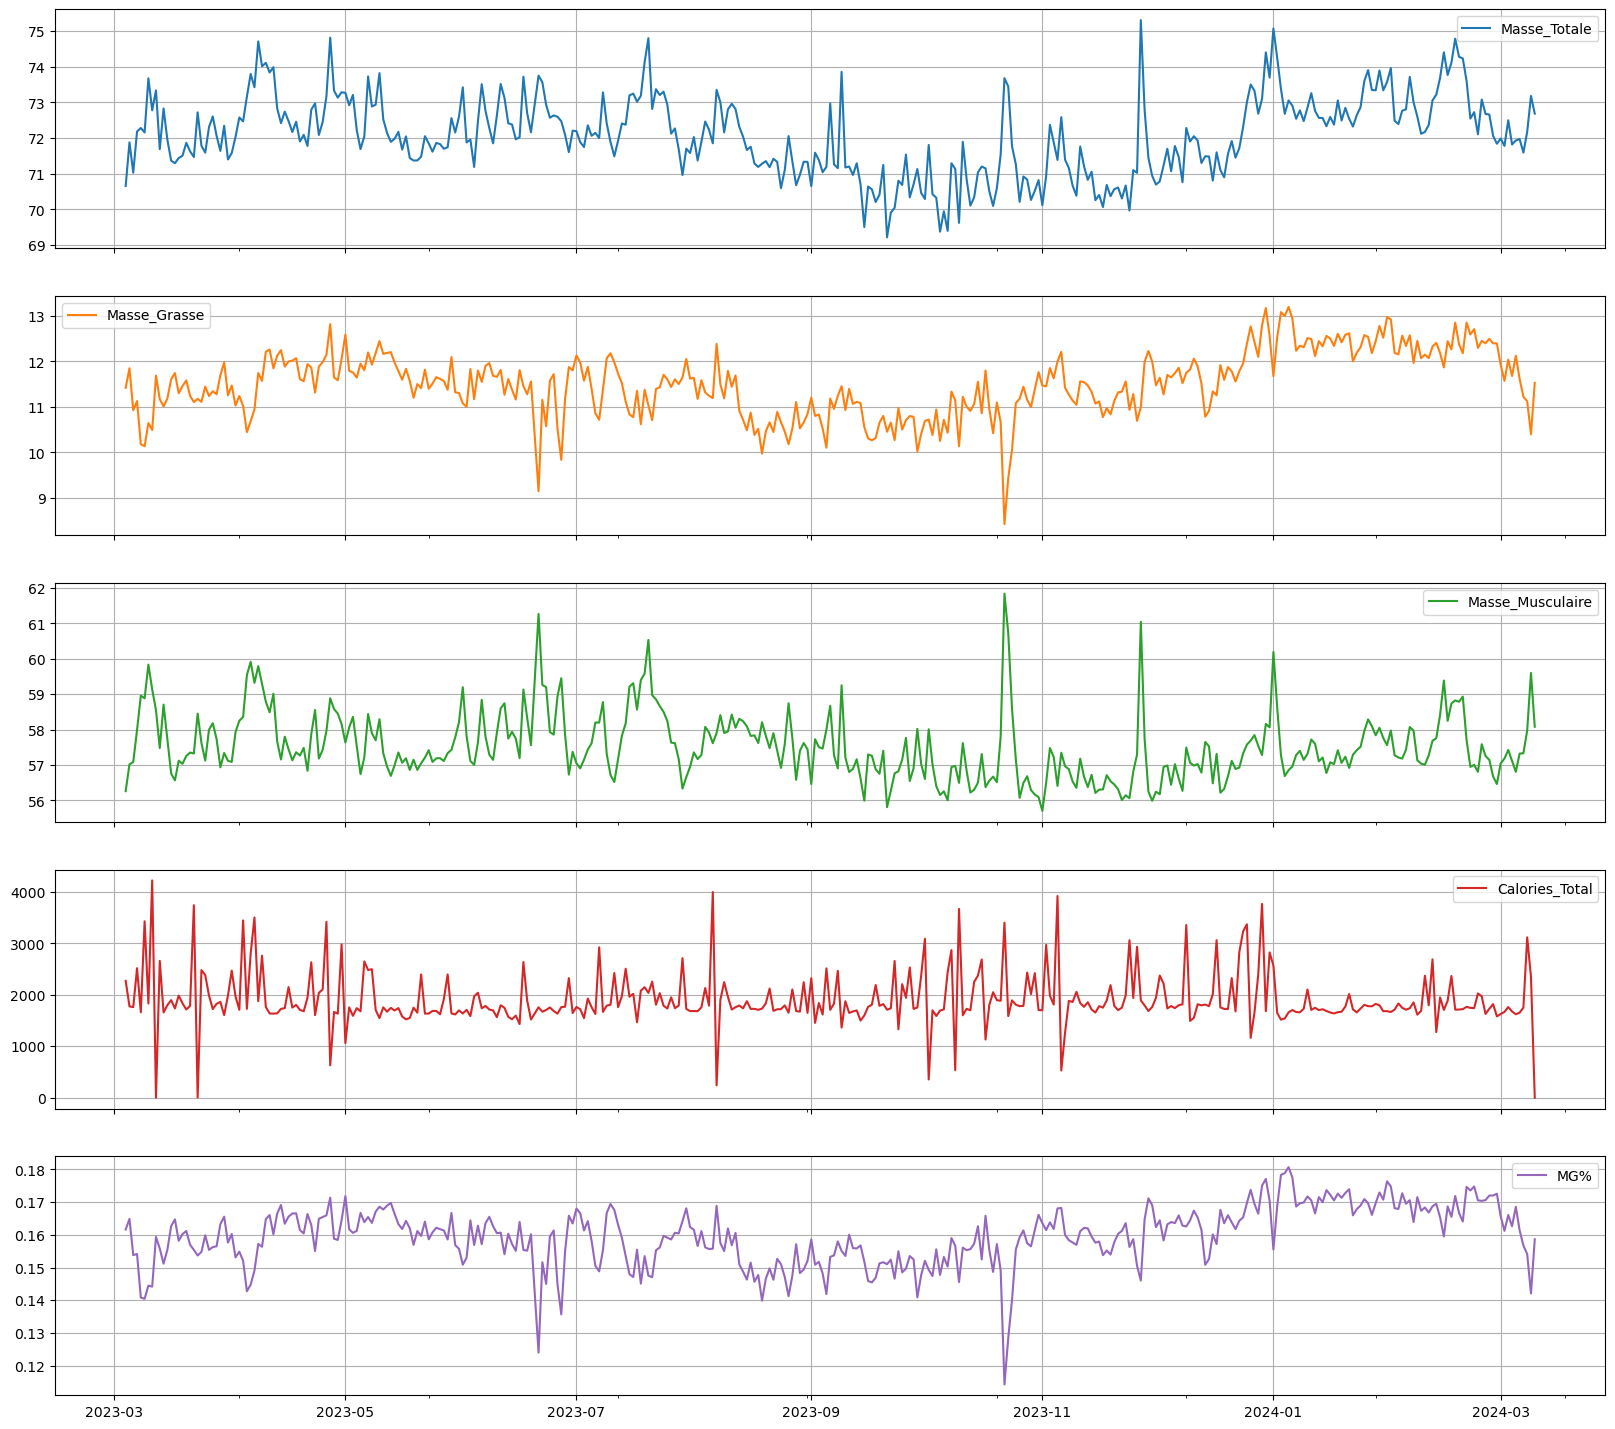

In [28]:
cols_to_display = ['Masse_Totale', 'Masse_Grasse', 'Masse_Musculaire', 'Calories_Total', 'MG%']

df_all_masses[cols_to_display].plot(subplots=True, figsize=(20,18), grid=True)
plt.show()

### Construction d'une autre dataframe avec juste masse totale et masse grasse (depuis Septembre 2020)

In [29]:
# df_mtmg_only est la dataframe avec les masses Totale et Grasse (depuis 2020)

df_mtmg_only = df_all.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique'])

In [30]:
df_mtmg_only.fillna(0, inplace=True)

In [31]:
# df_mtmg_only.dropna(inplace=True)
df_mtmg_only

,Masse_Totale,Masse_Grasse,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,Calories_Snacks,Lipides_Breakfast,Lipides_Dinner,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2020-08-09,107.250000,37.190000,0.346760,1883.2960,683.1,504.7,615.5,58.0,25.0,30.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1861.3
2020-08-11,104.650000,33.150000,0.316770,1914.4000,557.5,413.1,801.8,0.0,12.9,21.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1772.4
2020-08-12,104.350000,33.800000,0.323910,1893.8800,690.1,563.3,640.9,0.0,25.0,13.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1894.3
2020-08-13,104.400000,34.340000,0.328927,1883.2960,723.0,541.3,558.3,0.0,29.0,19.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1822.6
2020-08-14,104.500000,33.850000,0.323923,1896.0400,723.0,637.9,530.6,0.0,29.0,27.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1891.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06,71.974000,11.616000,0.161391,1673.7328,1361.4,290.8,0.0,0.0,44.7,4.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,1652.2
2024-03-07,71.593333,11.222000,0.156746,1674.0208,1212.3,157.5,380.0,0.0,32.2,2.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,1749.8
2024-03-08,72.173125,11.122500,0.154108,1688.6935,1019.9,987.2,1109.2,0.0,21.9,10.1,...,0.0,0.0,0.0,0.0,0.0,195.0,0.0,0.0,635.0,3116.3
2024-03-09,73.181875,10.396875,0.142068,1726.1560,1769.0,579.0,0.0,0.0,51.6,19.7,...,0.0,248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2348.0


In [32]:
df_mtmg_only.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1293 entries, 2020-08-09 to 2024-03-10
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Masse_Totale                         1293 non-null   float64
 1   Masse_Grasse                         1293 non-null   float64
 2   MG%                                  1293 non-null   float64
 3   BMR                                  1293 non-null   float64
 4   Calories_Breakfast                   1293 non-null   float64
 5   Calories_Dinner                      1293 non-null   float64
 6   Calories_Lunch                       1293 non-null   float64
 7   Calories_Snacks                      1293 non-null   float64
 8   Lipides_Breakfast                    1293 non-null   float64
 9   Lipides_Dinner                       1293 non-null   float64
 10  Lipides_Lunch                        1293 non-null   float64
 11  Lipides_Snacks      

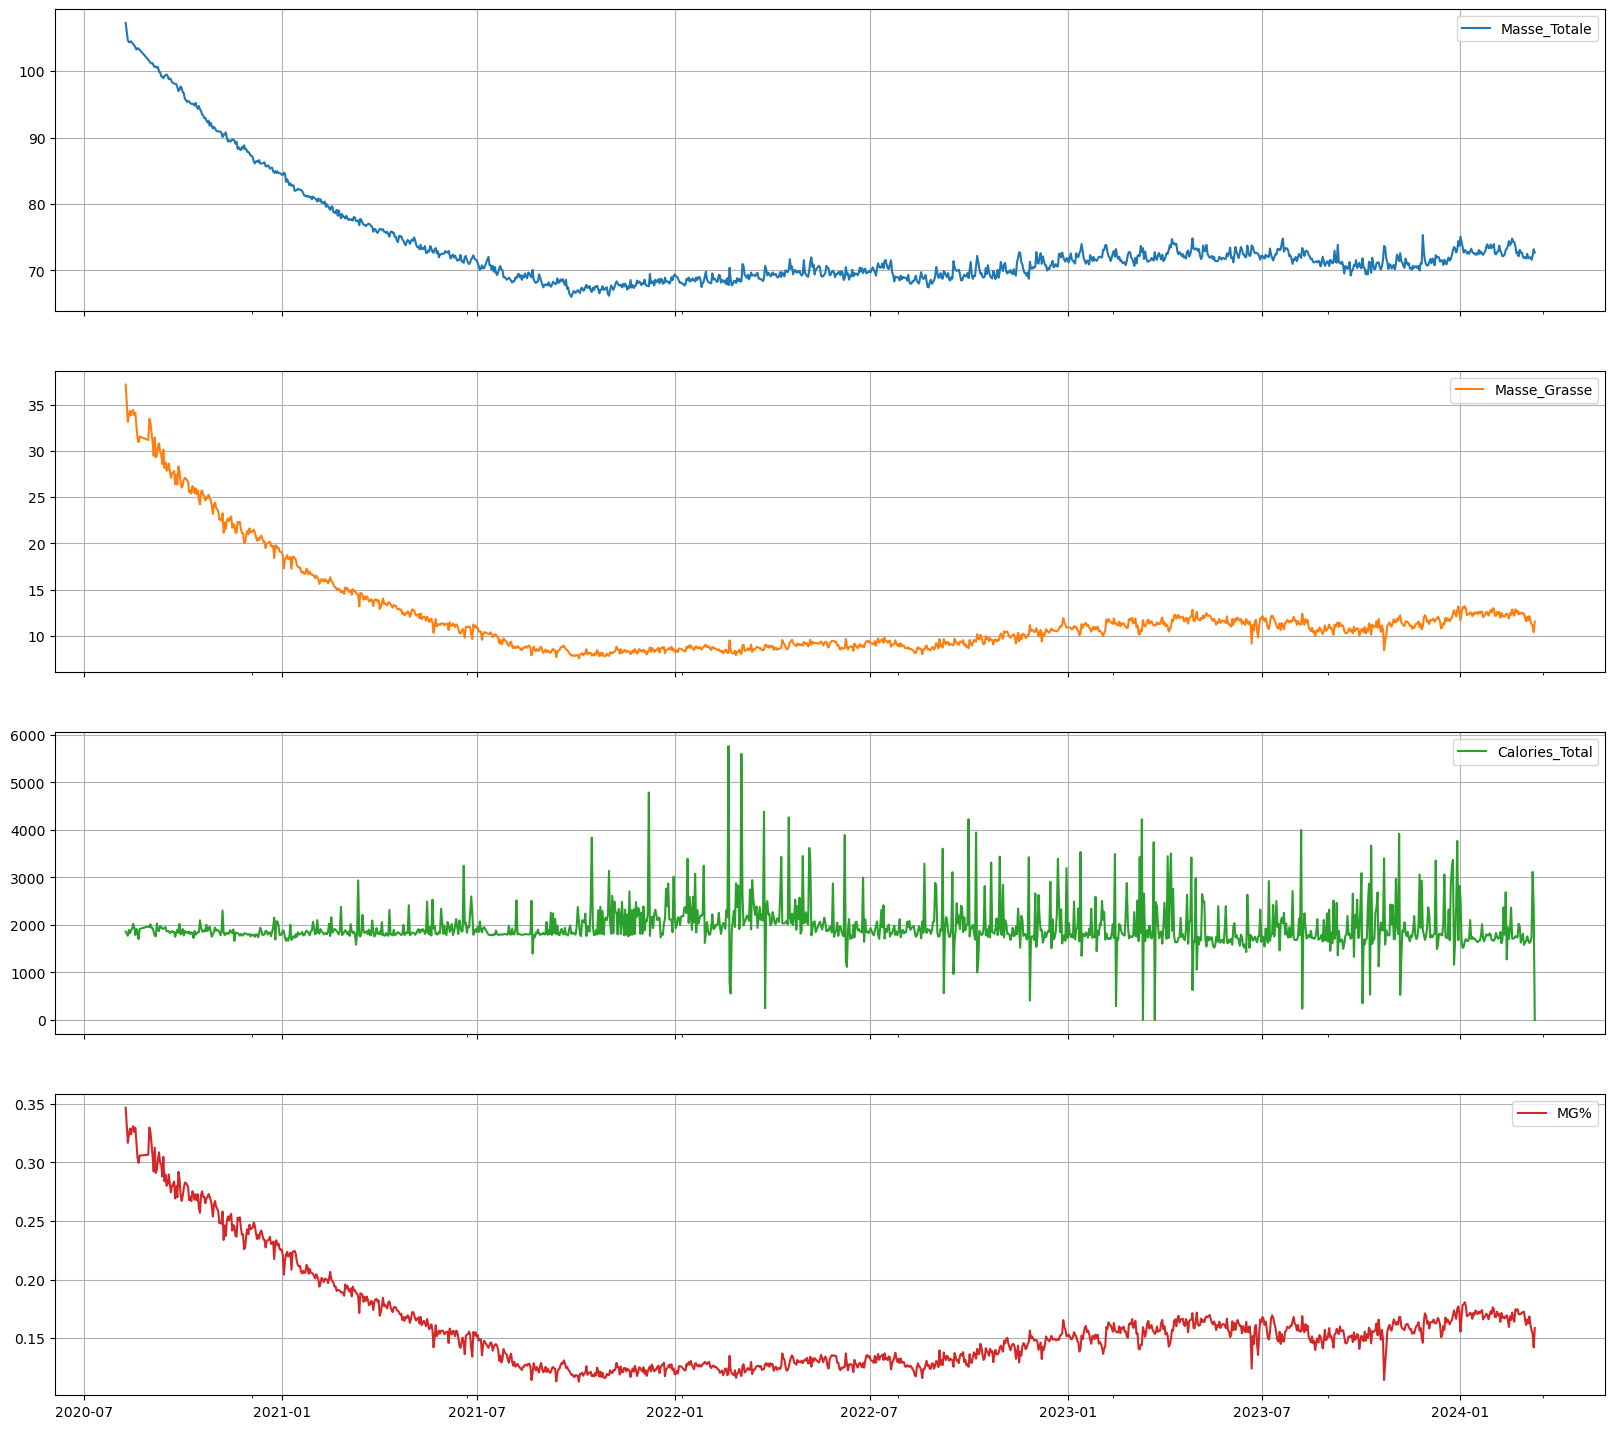

In [33]:
cols_to_display = ['Masse_Totale', 'Masse_Grasse', 'Calories_Total', 'MG%']

df_mtmg_only[cols_to_display].plot(subplots=True, figsize=(20,18), grid=True)
plt.show()

### Constitution du dataset pour training d'un premier modèle - masse totale et masse grasse seulement

In [34]:
PAST = 3 # jours dans le passé
FUTURE = 1 # nombre de jours prédiction dans le futur

L = len(df_mtmg_only)  # nombre de jours avec données MT et MG

In [35]:
df_mtmg_only

,Masse_Totale,Masse_Grasse,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,Calories_Snacks,Lipides_Breakfast,Lipides_Dinner,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2020-08-09,107.250000,37.190000,0.346760,1883.296,683.1,504.7,615.5,58.0,25.0,30.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1861.3
2020-08-11,104.650000,33.150000,0.316770,1914.400,557.5,413.1,801.8,0.0,12.9,21.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1772.4
2020-08-12,104.350000,33.800000,0.323910,1893.880,690.1,563.3,640.9,0.0,25.0,13.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1894.3
2020-08-13,104.400000,34.340000,0.328927,1883.296,723.0,541.3,558.3,0.0,29.0,19.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1822.6
2020-08-14,104.500000,33.850000,0.323923,1896.040,723.0,637.9,530.6,0.0,29.0,27.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1891.5
2020-08-15,104.250000,34.280000,0.328825,1881.352,707.3,337.1,880.9,0.0,25.0,7.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1925.3
2020-08-16,104.050000,34.430000,0.330899,1873.792,743.4,572.5,705.8,0.0,29.1,25.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021.7
2020-08-17,103.900000,33.880000,0.326083,1882.432,702.6,702.8,541.1,0.0,28.9,17.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1946.5
2020-08-18,103.550000,34.130000,0.329599,1869.472,743.4,505.0,541.1,0.0,29.1,4.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1789.5
2020-08-19,103.250000,32.650000,0.316223,1894.960,743.4,528.1,643.3,0.0,29.1,17.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1914.8


In [36]:
columns = df_mtmg_only.columns

# data frame columns to be used as targets
Y_columns = ['Masse_Totale', 'Masse_Grasse']  

# data frame columns to be used as features
X_columns = ['Calories_Breakfast',
       'Calories_Dinner', 'Calories_Lunch', 'Calories_Snacks',
       # 'Lipides_Breakfast', 'Lipides_Dinner', 'Lipides_Lunch',
       # 'Lipides_Snacks', 'Glucides_Breakfast', 'Glucides_Dinner',
       # 'Glucides_Lunch', 'Glucides_Snacks', 'Proteines_Breakfast',
       # 'Proteines_Dinner', 'Proteines_Lunch', 'Proteines_Snacks',
       # 'BOXING_exo_duree', 'CROSS-COUNTRY_SKIING_exo_duree',
       # 'DOWNHILL_SKIING_exo_duree', 
       'INDOOR_ROWING_exo_duree',
       'JOGGING_exo_duree', 
       # 'ROWING_exo_duree', 
       'RUNNING_exo_duree',
       'STRENGTH_TRAINING_exo_duree', 
       # 'SWIMMING_exo_duree',
       # 'TREADMILL_RUNNING_exo_duree', 
       'WALKING_exo_duree',
       # 'BOXING_exo_cals_bruts', 'CROSS-COUNTRY_SKIING_exo_cals_bruts',
       # 'DOWNHILL_SKIING_exo_cals_bruts', 
       'INDOOR_ROWING_exo_cals_bruts',
       'JOGGING_exo_cals_bruts', 
       # 'ROWING_exo_cals_bruts',
       'RUNNING_exo_cals_bruts', 'STRENGTH_TRAINING_exo_cals_bruts',
       # 'SWIMMING_exo_cals_bruts', 'TREADMILL_RUNNING_exo_cals_bruts',
       'WALKING_exo_cals_bruts', 
       'Calories_Total'] 

# full_X_columns = ['Calories_Breakfast',
#        'Calories_Dinner', 'Calories_Lunch', 'Calories_Snacks',
#        'Lipides_Breakfast', 'Lipides_Dinner', 'Lipides_Lunch',
#        'Lipides_Snacks', 'Glucides_Breakfast', 'Glucides_Dinner',
#        'Glucides_Lunch', 'Glucides_Snacks', 'Proteines_Breakfast',
#        'Proteines_Dinner', 'Proteines_Lunch', 'Proteines_Snacks',
#        'BOXING_exo_duree', 'CROSS-COUNTRY_SKIING_exo_duree',
#        'DOWNHILL_SKIING_exo_duree', 'INDOOR_ROWING_exo_duree',
#        'JOGGING_exo_duree', 'ROWING_exo_duree', 'RUNNING_exo_duree',
#        'STRENGTH_TRAINING_exo_duree', 'SWIMMING_exo_duree',
#        'TREADMILL_RUNNING_exo_duree', 'WALKING_exo_duree',
#        'BOXING_exo_cals_bruts', 'C dropSTRENGTH_TRAINING_exo_cals_bruts',
#        'SWIMMING_exo_cals_bruts', 'TREADMILL_RUNNING_exo_cals_bruts',
#        'WALKING_exo_cals_bruts', 'Calories_Total'] # all features

In [37]:
class CreateDataset():
    """Create dataset for training, looking backward and forward
    """

    def __init__(
        self,
        df = None,
        past = None,
        future = None,
        target_columns = None,
        features_columns = None
    ):
        """
        Args:
            df (Dataframe, optional): Dataframe to use as souce. Defaults to df_mtmg_only.
            past (_type_, optional): number of days of past history to put in the features. Defaults to PAST.
            future (_type_, optional): numnber of days to use to create targets. Defaults to FUTURE.
            target_columns (_type_, optional): list of columns in df to use to create targets. Defaults to Y_columns. Typically mass values.
            features_columns (_type_, optional): list of columns in df to use as features. Defaults to X_columns. Typically food and exercices calories.
        """

        if df is None:
            self.df = df_mtmg_only
        else:
            self.df = df
            
        if past is None:
            self.past = PAST
        else:
            self.past = past
        
        if future is None:
            self.future = FUTURE
        else:
            self.future = future
            
        if target_columns is None:
            self.target_columns = Y_columns
        else:
            self.target_columns = target_columns
            
        if features_columns is None:
            self.features_columns = X_columns
        else:
            self.features_columns = features_columns
        
    def get_dataset(self):
        # prepare np.arrays to get features and targets
        timesteps = len(self.df) - self.future - self.past + 1 # number of time steps in total
        
        width_features_past = len(self.target_columns) + len(self.features_columns) # shape of the features block made of past mass and calories values
        widht_features_future = len(self.features_columns) # shape of the features block made of future calories values
        width_targets = len(self.target_columns) # shape of target blocks
        
        X_past = np.zeros(shape=(timesteps, self.past, width_features_past))
        X_future = np.zeros(shape=(timesteps, self.future-1, widht_features_future))
        y = np.zeros(shape=(timesteps, self.future, width_targets))
        
        # concatenate by past days and future days
        # 1/ row indexes in the dataframe df vary from 0 to len(df)-1 included
        # 2/ here, loop index J varies from PAST-1 to len(df)-1-FUTURE included
        # 3/ the block [J-PAST-1 to J] x [X_columns, Y_colums] is used as first part of features
        # 4/ the block [J+1 to J+FUTURE] x X_columns is used as second block of features
        # 5/ the block [J to J+FUTURE-1] x target_values_columns is used as target block
        
        for i, j in tqdm(enumerate(range(self.past-1, len(self.df)-self.future))):
            # print(f'i = {i}, j={j}')
            # assemble
            X_past[i] = self.df[self.target_columns + self.features_columns].iloc[j-self.past+1:j+1,:].to_numpy()
            X_future[i] = self.df[self.features_columns].iloc[j+1:j+self.future,:].to_numpy()
            y[i] = self.df[self.target_columns].iloc[j+1:j+self.future+1,:].to_numpy()
            
        return X_past, X_future, y
    
    def __repr__(self):
        representation = 'objet Create Dataset\n' + f'Dataset initial longueur {len(self.df)} jour(s)\n' + f'fenêtre PAST = {self.past} jour(s)\n' + f'fenêtre FUTURE = {self.future} jour(s)\n' 
        return representation

In [38]:
obj = CreateDataset(past=7, future=3)

print(obj)

objet Create Dataset
Dataset initial longueur 1293 jour(s)
fenêtre PAST = 7 jour(s)
fenêtre FUTURE = 3 jour(s)



In [39]:
X_past, X_future, y = obj.get_dataset()

1284it [00:21, 60.60it/s]


In [40]:
print(X_past.shape)
X_past[0]

(1284, 7, 17)


array([[ 107.25,   37.19,  683.1 ,  504.7 ,  615.5 ,   58.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  , 1861.3 ],
       [ 104.65,   33.15,  557.5 ,  413.1 ,  801.8 ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  , 1772.4 ],
       [ 104.35,   33.8 ,  690.1 ,  563.3 ,  640.9 ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  , 1894.3 ],
       [ 104.4 ,   34.34,  723.  ,  541.3 ,  558.3 ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  , 1822.6 ],
       [ 104.5 ,   33.85,  723.  ,  637.9 ,  530.6 ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  , 1891.5 ],
       [ 104.25,   34.28,  707.3 ,  337.1 ,  880.9 ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0

In [41]:
print(X_future.shape)
X_future[0]

(1284, 2, 15)


array([[ 702.6,  702.8,  541.1,    0. ,    0. ,    0. ,    0. ,    0. ,
           0. ,    0. ,    0. ,    0. ,    0. ,    0. , 1946.5],
       [ 743.4,  505. ,  541.1,    0. ,    0. ,    0. ,    0. ,    0. ,
           0. ,    0. ,    0. ,    0. ,    0. ,    0. , 1789.5]])

In [42]:
print(y.shape)
y[0]

(1284, 3, 2)


array([[103.9 ,  33.88],
       [103.55,  34.13],
       [103.25,  32.65]])

# Prédictions J+1 avec PAST = 1 jour

In [43]:
obj = CreateDataset(past=1, future=1)

print(obj)

objet Create Dataset
Dataset initial longueur 1293 jour(s)
fenêtre PAST = 1 jour(s)
fenêtre FUTURE = 1 jour(s)



In [44]:
X_past, X_future, y = obj.get_dataset()

1292it [00:22, 56.70it/s]


In [45]:
print(f'X_past shape = {X_past.shape}')
print(f'X_future.shape = {X_future.shape}')
print(f'y shape = {y.shape}')

X_past shape = (1292, 1, 17)
X_future.shape = (1292, 0, 15)
y shape = (1292, 1, 2)


In [46]:
X_past = np.reshape(X_past, newshape=(X_past.shape[0],-1))
y = y.squeeze()

print(f'X_past : shape = {X_past.shape}')
print(f'y : shape = {y.shape}')

X_past : shape = (1292, 17)
y : shape = (1292, 2)


In [47]:
X_past[0]

array([ 107.25,   37.19,  683.1 ,  504.7 ,  615.5 ,   58.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  , 1861.3 ])

In [48]:
y[0]

array([104.65,  33.15])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_past, y, test_size=0.2, random_state=42)

In [50]:
models_results = {}

### Baseline : pred(J+1) = valeur (J)

In [51]:
y_pred = X_test[:,:2].squeeze()

In [52]:
def affiche_resultats(model_name, models_results, y_pred, y_test):
    """Utility function pour afficher les résultats du modèle

    Args:
        model_name (_type_): _description_
        y_pred (_type_): _description_
        y_test (_type_): _description_
    """
    
    subset = 50

    mse = tf.keras.losses.MeanSquaredError()
    mae = tf.keras.losses.MeanAbsoluteError()

    models_results[model_name] = {}

    fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(20,4))

    for i, name in enumerate(['masse_totale', 'masse_grasse']):
        ax[i].plot(y_pred[:subset,i], label='pred')
        ax[i].plot(y_test.squeeze()[:subset,i], label='ground truth')
        err_mse = mse(y_pred[:,i], y_test.squeeze()[:,i]).numpy()
        err_mae = mae(y_pred[:,i], y_test.squeeze()[:,i]).numpy()
        ax[i].set_title(model_name + f' - {name} - mse = {err_mse:.2f} - mae = {err_mae:.2f}')
        k = name + '_mse'
        models_results[model_name][k] = err_mse
        k = name + '_mae'
        models_results[model_name][k] = err_mae

2024-03-10 10:39:01.435894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 10:39:01.442763: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


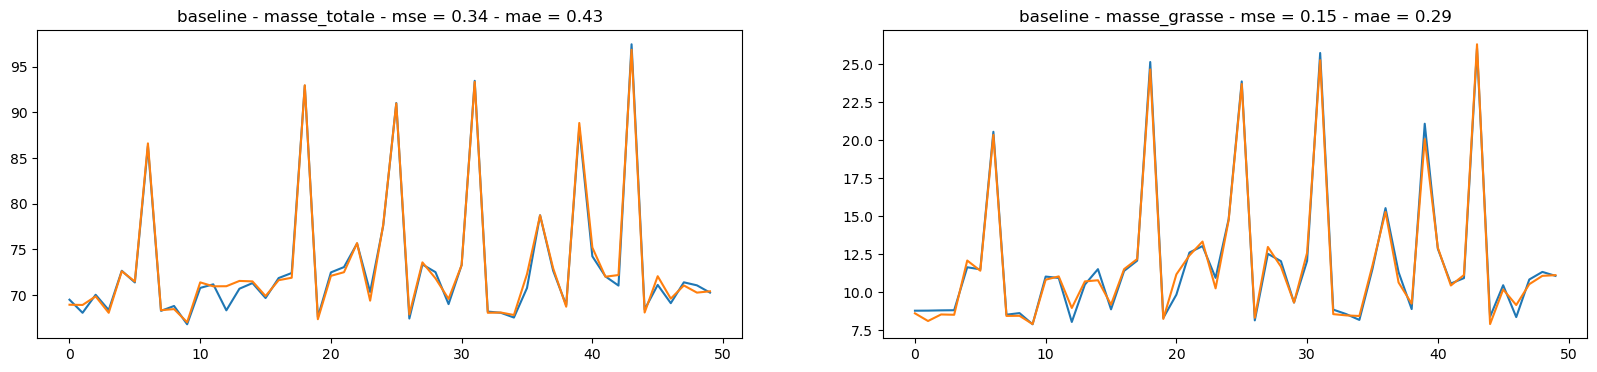

In [53]:
affiche_resultats(model_name='baseline', models_results=models_results, y_pred=y_pred, y_test=y_test)

### regression linéaire simple

In [54]:
lr = LinearRegression()
lr.fit(X_train.squeeze(), y_train.squeeze())
y_pred = lr.predict(X_test.squeeze())

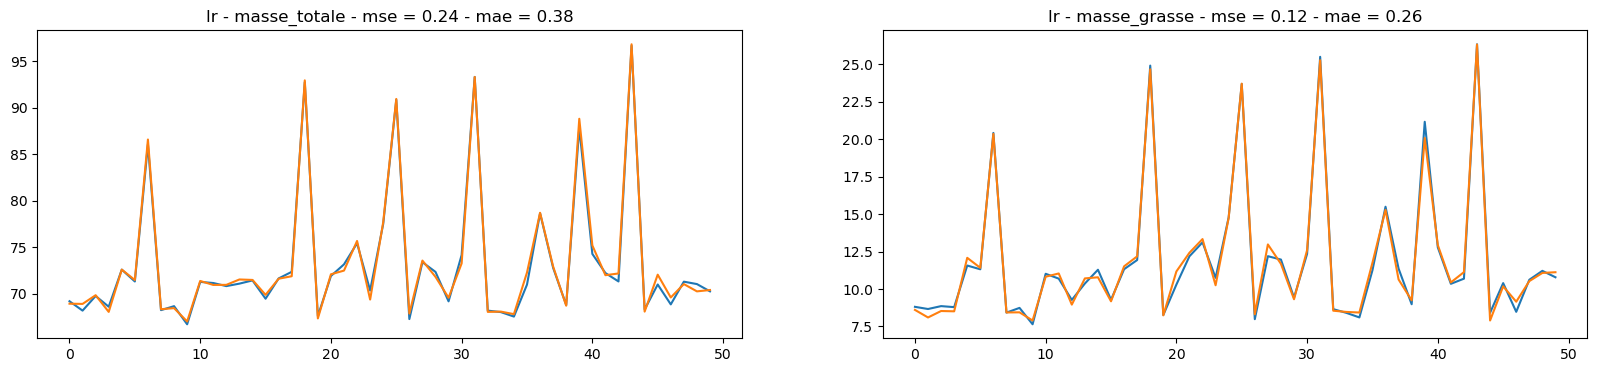

In [55]:
affiche_resultats(model_name='lr', models_results=models_results, y_pred=y_pred, y_test=y_test)

### MLP

In [56]:
def create_and_fit_mlp(X_train, X_test, y_train, y_test):
    """Utility function to instantiate a simple MLP, train it, and return it

    Args:
        X_train (_type_): _description_
        X_test (_type_): _description_
        y_train (_type_): _description_
        y_test (_type_): _description_

    Returns:
        _type_: _description_
    """
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    y_train_scaled = y_scaler.fit_transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    
    mlp = tf.keras.models.Sequential(
        [
        tf.keras.layers.Dense(units=16, input_shape=(X_train.shape[1],), activation='relu'),
        tf.keras.layers.Dense(units=16, activation='relu'),
        tf.keras.layers.Dense(units=2)]
    )
    
    loss = tf.keras.losses.MeanSquaredError()

    mlp.compile(
        optimizer='rmsprop',
        loss=loss,
    )
    
    cb = tf.keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True
    )
    
    history = mlp.fit(
        x=X_train_scaled,
        y=y_train_scaled,
        epochs=1000,
        validation_data=(X_test_scaled, y_test_scaled),
        callbacks=[cb]
    )
    
    y_pred = y_scaler.inverse_transform(mlp.predict(X_test_scaled))
    
    return mlp, y_pred

In [57]:
mlp, y_pred = create_and_fit_mlp(X_train, X_test, y_train, y_test)

Epoch 1/1000
33/33 [==============================] - 6s 81ms/step - loss: 1.1458 - val_loss: 0.8691
Epoch 2/1000
33/33 [==============================] - 1s 42ms/step - loss: 0.8423 - val_loss: 0.6489
Epoch 3/1000
33/33 [==============================] - 2s 50ms/step - loss: 0.6280 - val_loss: 0.4304
Epoch 4/1000
33/33 [==============================] - 2s 48ms/step - loss: 0.3592 - val_loss: 0.1871
Epoch 5/1000
33/33 [==============================] - 2s 56ms/step - loss: 0.1598 - val_loss: 0.0861
Epoch 6/1000
33/33 [==============================] - 1s 43ms/step - loss: 0.0791 - val_loss: 0.0546
Epoch 7/1000
33/33 [==============================] - 2s 54ms/step - loss: 0.0510 - val_loss: 0.0441
Epoch 8/1000
33/33 [==============================] - 1s 41ms/step - loss: 0.0377 - val_loss: 0.0417
Epoch 9/1000
33/33 [==============================] - 2s 52ms/step - loss: 0.0301 - val_loss: 0.0326
Epoch 10/1000
33/33 [==============================] - 2s 50ms/step - loss: 0.0250 - val_lo

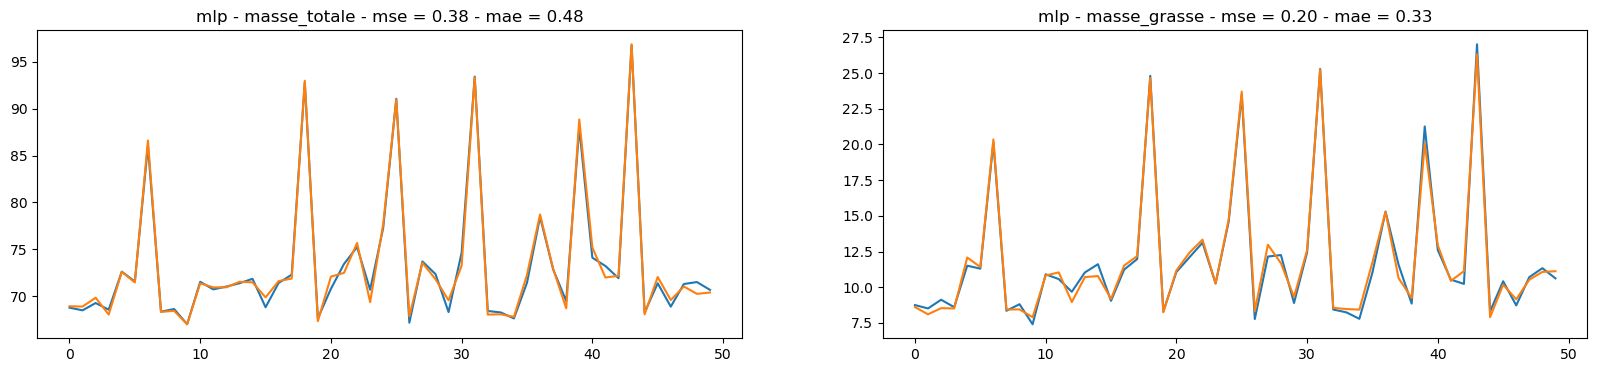

In [58]:
affiche_resultats(model_name='mlp', models_results=models_results, y_pred=y_pred, y_test=y_test)

### Régression linéaire Bayesienne

In [59]:
from sklearn.linear_model import BayesianRidge

In [60]:
X_train.shape

(1033, 17)

In [61]:
y_train.shape

(1033, 2)

In [62]:
# sur Masse Totale
lrr_mt = BayesianRidge()
lrr_mt.fit(X_train.squeeze(), y_train.squeeze()[:,0])
y_pred_mt = lrr_mt.predict(X_test.squeeze())

# sur Masse Grasse
lrr_mg = BayesianRidge()
lrr_mg.fit(X_train.squeeze(), y_train.squeeze()[:,1])
y_pred_mg = lrr_mg.predict(X_test.squeeze())

In [63]:
# concat
y_pred = np.stack((y_pred_mt, y_pred_mg), axis=1)

In [64]:
y_pred.shape

(259, 2)

In [65]:
y_test.shape

(259, 2)

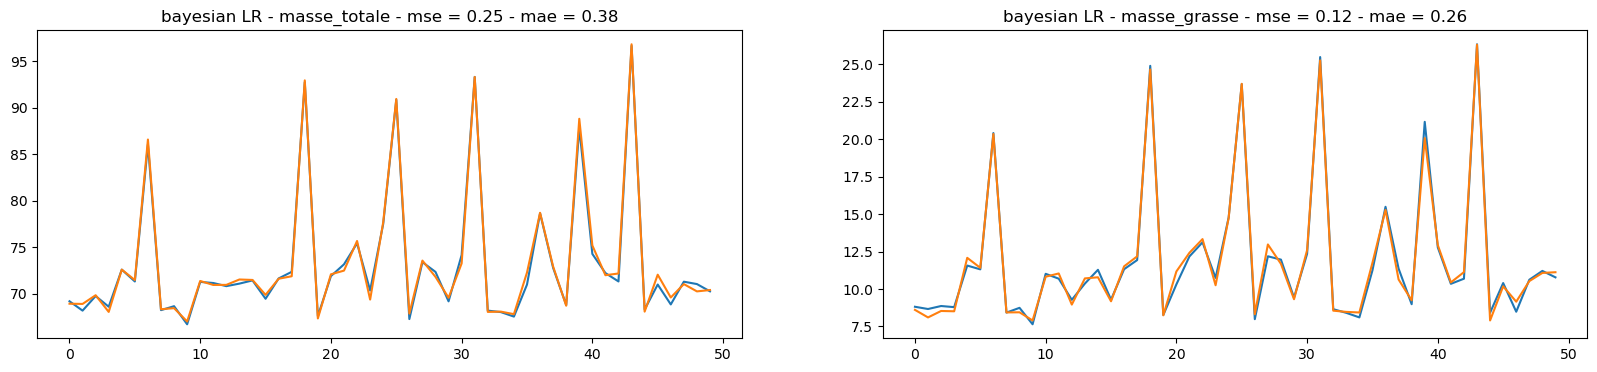

In [66]:
affiche_resultats(model_name='bayesian LR', models_results=models_results, y_pred=y_pred, y_test=y_test)

### Résultats

In [67]:
pprint(models_results)

{'baseline': {'masse_grasse_mae': 0.2894693072907359,
              'masse_grasse_mse': 0.15358528365762042,
              'masse_totale_mae': 0.4308315991708846,
              'masse_totale_mse': 0.33563220515412423},
 'bayesian LR': {'masse_grasse_mae': 0.2643316255646277,
                 'masse_grasse_mse': 0.1230791876195727,
                 'masse_totale_mae': 0.3843264751461218,
                 'masse_totale_mse': 0.2450658178639346},
 'lr': {'masse_grasse_mae': 0.2637255591325729,
        'masse_grasse_mse': 0.12286301186512537,
        'masse_totale_mae': 0.38386208446399483,
        'masse_totale_mse': 0.24467847862361652},
 'mlp': {'masse_grasse_mae': 0.32806148041136335,
         'masse_grasse_mse': 0.20362014063056508,
         'masse_totale_mae': 0.47736662139897873,
         'masse_totale_mse': 0.3839177751280628}}


### Meilleur modèle J+1 avec PAST=1 jour : Linear Regression

In [68]:
# Coefficients Bayesiens

print(f'MT : Estimated noise std dev = {np.sqrt(1/lrr_mt.alpha_)}')
print(f'MG : Estimated noise std dev = {np.sqrt(1/lrr_mg.alpha_)}')

MT : Estimated noise std dev = 0.5559905216763902
MG : Estimated noise std dev = 0.4191401753295263


In [69]:
lrr_mt.coef_

array([ 8.23531646e-01,  2.50833559e-01,  1.97924131e-04,  2.29667874e-04,
        1.12721319e-04, -2.32553769e-05,  1.54573713e-05,  4.85146599e-04,
        1.29088573e-04,  4.93986235e-05, -1.40071999e-05, -4.47954518e-04,
       -2.90249174e-03, -1.58189978e-03, -8.40541716e-04,  5.18658303e-04,
        5.17058003e-04])

In [70]:
lrr_mg.coef_

array([ 1.64143909e-01,  7.42519260e-01, -1.22523954e-04,  4.25622626e-05,
        2.03750486e-04,  5.45157757e-05, -8.91403864e-05, -4.06244994e-04,
       -5.33810906e-04, -1.09845001e-05,  6.87341688e-06,  3.35585514e-04,
        2.22376287e-03,  3.02871962e-03, -1.16556985e-04, -4.16827597e-04,
        1.78304587e-04])

# Prédiction J+1 avec les PAST=7 derniers jours

In [72]:
PAST = 7

obj = CreateDataset(past=PAST, future=1)

print(obj)

objet Create Dataset
Dataset initial longueur 1293 jour(s)
fenêtre PAST = 7 jour(s)
fenêtre FUTURE = 1 jour(s)



In [73]:
X_past, X_future, y = obj.get_dataset()

print(f'X_past shape = {X_past.shape}')
print(f'X_future shape = {X_future.shape}')
print(f'y shape = {y.shape}')

1286it [00:20, 62.17it/s]

X_past shape = (1286, 7, 17)
X_future shape = (1286, 0, 15)
y shape = (1286, 1, 2)


In [74]:
X_past = np.reshape(X_past, newshape=(X_past.shape[0],-1))
y = y.squeeze()

print(f'X_past : shape = {X_past.shape}')
print(f'y : shape = {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X_past, y, test_size=0.2, random_state=42)

X_past : shape = (1286, 119)
y : shape = (1286, 2)


In [75]:
models_results_2 = {}

### Linear Regression

In [76]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

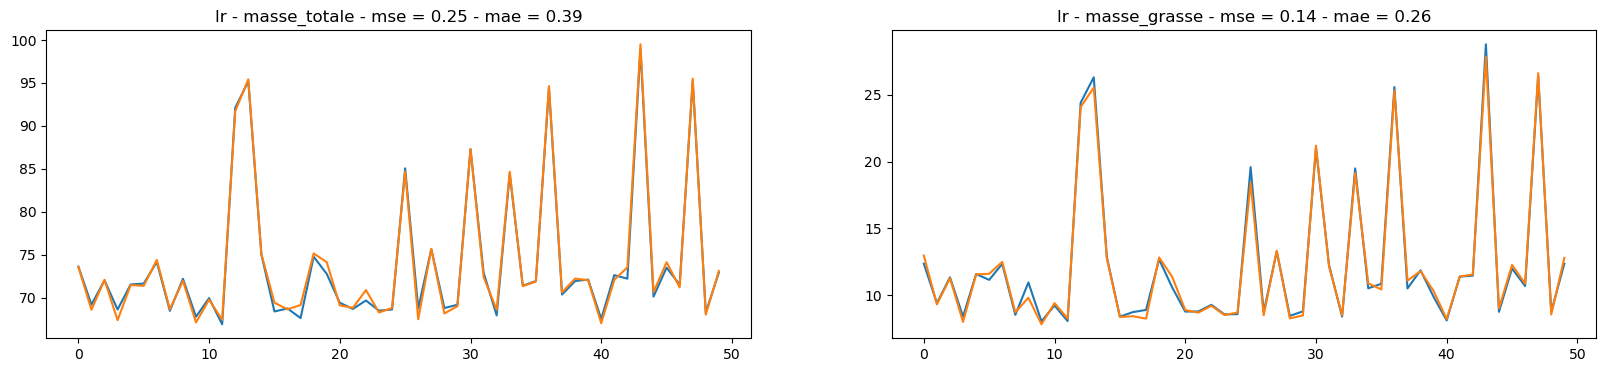

In [77]:
affiche_resultats(model_name='lr', models_results=models_results_2, y_pred=y_pred, y_test=y_test)

### Réseau MLP simple

In [78]:
mlp, y_pred = create_and_fit_mlp(X_train, X_test, y_train, y_test)

Epoch 1/1000
33/33 [==============================] - 5s 64ms/step - loss: 0.6771 - val_loss: 0.3161
Epoch 2/1000
33/33 [==============================] - 1s 40ms/step - loss: 0.1972 - val_loss: 0.1422
Epoch 3/1000
33/33 [==============================] - 2s 50ms/step - loss: 0.0925 - val_loss: 0.1033
Epoch 4/1000
33/33 [==============================] - 2s 53ms/step - loss: 0.0603 - val_loss: 0.0795
Epoch 5/1000
33/33 [==============================] - 1s 31ms/step - loss: 0.0454 - val_loss: 0.0682
Epoch 6/1000
33/33 [==============================] - 2s 60ms/step - loss: 0.0359 - val_loss: 0.0566
Epoch 7/1000
33/33 [==============================] - 2s 64ms/step - loss: 0.0293 - val_loss: 0.0491
Epoch 8/1000
33/33 [==============================] - 2s 59ms/step - loss: 0.0244 - val_loss: 0.0472
Epoch 9/1000
33/33 [==============================] - 2s 49ms/step - loss: 0.0209 - val_loss: 0.0408
Epoch 10/1000
33/33 [==============================] - 2s 48ms/step - loss: 0.0183 - val_lo

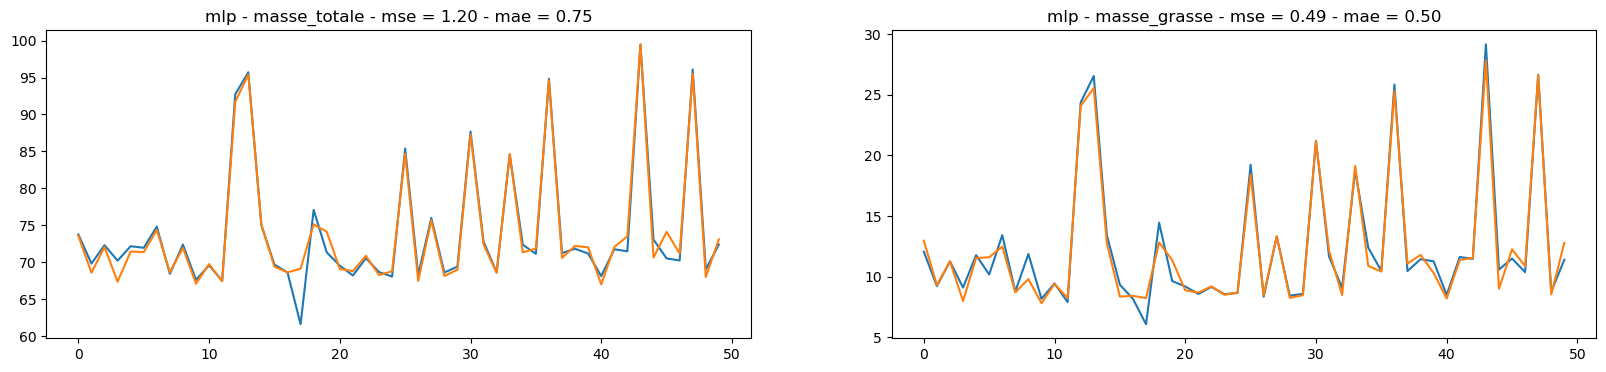

In [79]:
affiche_resultats(model_name='mlp', models_results=models_results_2, y_pred=y_pred, y_test=y_test)

### Regression Lineaire Bayesienne

In [80]:
# sur Masse Totale
lrr_mt = BayesianRidge()
lrr_mt.fit(X_train.squeeze(), y_train.squeeze()[:,0])
y_pred_mt = lrr_mt.predict(X_test.squeeze())

# sur Masse Grasse
lrr_mg = BayesianRidge()
lrr_mg.fit(X_train.squeeze(), y_train.squeeze()[:,1])
y_pred_mg = lrr_mg.predict(X_test.squeeze())

In [81]:
# concat
y_pred = np.stack((y_pred_mt, y_pred_mg), axis=1)

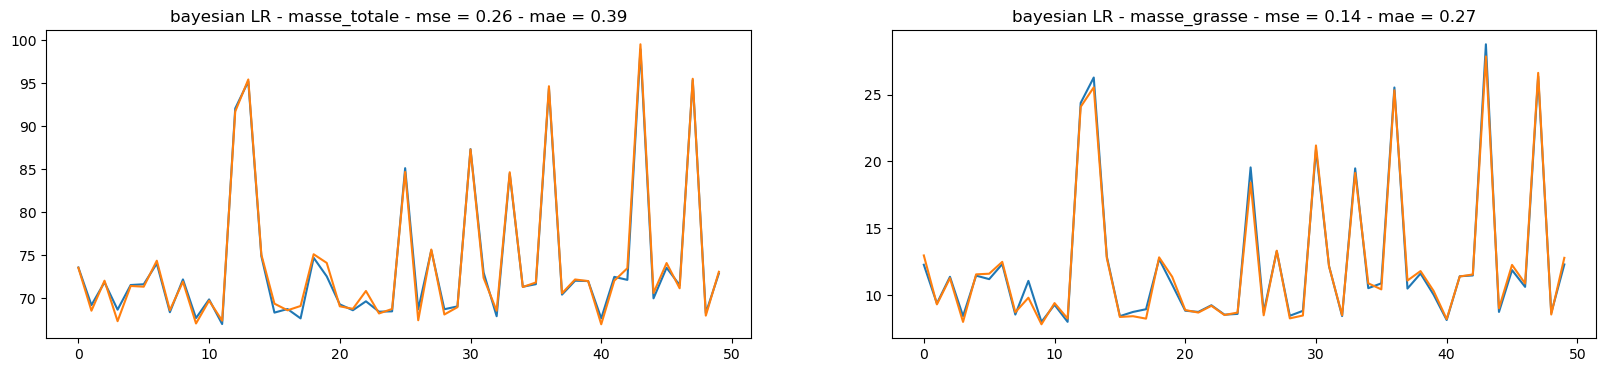

In [82]:
affiche_resultats(model_name='bayesian LR', models_results=models_results_2, y_pred=y_pred, y_test=y_test)

In [83]:
# Coefficients Bayesiens

print(f'MT : Estimated noise std dev = {np.sqrt(1/lrr_mt.alpha_)}')
print(f'MG : Estimated noise std dev = {np.sqrt(1/lrr_mg.alpha_)}')

MT : Estimated noise std dev = 0.5052817520404339
MG : Estimated noise std dev = 0.3694261098240904


In [84]:
lrr_mt.coef_

array([ 1.33597984e-02,  2.45342389e-02, -7.21692300e-05, -1.05328887e-04,
       -1.17383107e-04,  2.77183324e-04, -7.75604870e-05, -1.01716005e-04,
       -7.44566962e-04, -9.93474677e-06, -1.57544866e-05,  5.70201390e-04,
        3.34740341e-04,  5.37013251e-03,  8.28731331e-05,  6.92887759e-05,
       -1.76978818e-05,  4.76630266e-02,  3.84965799e-02, -9.78441419e-06,
       -6.87655601e-05, -2.87556226e-05,  3.03853909e-05,  7.91857444e-05,
       -1.52735585e-05,  8.23218179e-04, -3.74671289e-05, -1.72592896e-05,
       -4.38526657e-04,  1.18595488e-04, -6.10040230e-03,  2.90196199e-04,
       -7.64835251e-05, -7.69202004e-05,  4.80835326e-02,  5.27015486e-02,
       -6.77607116e-05, -7.70704380e-05,  9.69760495e-06,  9.42012471e-05,
        2.38962791e-05, -1.59700666e-04,  5.54537780e-04, -7.61477799e-06,
       -5.06271745e-06,  1.75184865e-04,  6.22912510e-04, -3.27011957e-03,
        2.65236619e-04,  5.17764665e-05, -4.09322962e-05,  9.13135817e-02,
        3.31457497e-02,  

In [85]:
pprint(models_results_2)

{'bayesian LR': {'masse_grasse_mae': 0.2722873617445447,
                 'masse_grasse_mse': 0.14193569332142417,
                 'masse_totale_mae': 0.38990147078864545,
                 'masse_totale_mse': 0.2583431053048909},
 'lr': {'masse_grasse_mae': 0.26134844132977436,
        'masse_grasse_mse': 0.1355847905912892,
        'masse_totale_mae': 0.3852190578369446,
        'masse_totale_mse': 0.25397815645501065},
 'mlp': {'masse_grasse_mae': 0.5047349630317,
         'masse_grasse_mse': 0.4875470926651396,
         'masse_totale_mae': 0.7521744763204963,
         'masse_totale_mse': 1.1995359806474852}}


### Meilleur modèle à J+1 avec PAST=7 jours : Linear Regression

# Conclusions

In [86]:
# avec PAST=1 jour

pprint('Résultats prédiction J+1 avec PAST=1 jour')
print(f'LR')
pprint(models_results['lr'])
print(f'Bayesian LR')
pprint(models_results['bayesian LR'])

print(f'\n')
# avec PAST=7 jours

pprint('Résultats prédiction J+1 avec PAST=7 jours')
print(f'LR')
pprint(models_results_2['lr'])
print(f'Bayesian LR')
pprint(models_results_2['bayesian LR'])

# écarts-types
print(f'\n')
pprint(f'Ecart type mesures Masse Totale : moyenne = {std_empiriques["Masse_Totale"].mean()}')
pprint(f'Ecart type mesures Masse Grasse : moyenne = {std_empiriques["Masse_Grasse"].mean()}')

'Résultats prédiction J+1 avec PAST=1 jour'
LR
{'masse_grasse_mae': 0.2637255591325729,
 'masse_grasse_mse': 0.12286301186512537,
 'masse_totale_mae': 0.38386208446399483,
 'masse_totale_mse': 0.24467847862361652}
Bayesian LR
{'masse_grasse_mae': 0.2643316255646277,
 'masse_grasse_mse': 0.1230791876195727,
 'masse_totale_mae': 0.3843264751461218,
 'masse_totale_mse': 0.2450658178639346}


'Résultats prédiction J+1 avec PAST=7 jours'
LR
{'masse_grasse_mae': 0.26134844132977436,
 'masse_grasse_mse': 0.1355847905912892,
 'masse_totale_mae': 0.3852190578369446,
 'masse_totale_mse': 0.25397815645501065}
Bayesian LR
{'masse_grasse_mae': 0.2722873617445447,
 'masse_grasse_mse': 0.14193569332142417,
 'masse_totale_mae': 0.38990147078864545,
 'masse_totale_mse': 0.2583431053048909}


'Ecart type mesures Masse Totale : moyenne = 0.10270092260777526'
'Ecart type mesures Masse Grasse : moyenne = 0.08626537469086287'


# Conclusions
- le meilleur modèle est la Régression Linéaire...
- l'erreur MSE ne diminue pas quand on augmente la fenêtre dans le passé !
- l'erreur de prédiction est supérieure au bruit de mesure (x3 MT, x2 MG)
- l'estimation Bayesienne du bruit est x5 le bruit de mesure sur MT, x4 le bruit de mesure sur MG

# Et si on moyenne pour diminuer le bruit ?

In [130]:
MOY = 3 # durée sur laquelle on va moyenner toutes les mesures

In [131]:
df_mtmg_only

,Masse_Totale,Masse_Grasse,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,Calories_Snacks,Lipides_Breakfast,Lipides_Dinner,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2020-08-09,107.250000,37.190000,0.346760,1883.2960,683.1,504.7,615.5,58.0,25.0,30.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1861.3
2020-08-11,104.650000,33.150000,0.316770,1914.4000,557.5,413.1,801.8,0.0,12.9,21.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1772.4
2020-08-12,104.350000,33.800000,0.323910,1893.8800,690.1,563.3,640.9,0.0,25.0,13.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1894.3
2020-08-13,104.400000,34.340000,0.328927,1883.2960,723.0,541.3,558.3,0.0,29.0,19.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1822.6
2020-08-14,104.500000,33.850000,0.323923,1896.0400,723.0,637.9,530.6,0.0,29.0,27.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1891.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06,71.974000,11.616000,0.161391,1673.7328,1361.4,290.8,0.0,0.0,44.7,4.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,1652.2
2024-03-07,71.593333,11.222000,0.156746,1674.0208,1212.3,157.5,380.0,0.0,32.2,2.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,1749.8
2024-03-08,72.173125,11.122500,0.154108,1688.6935,1019.9,987.2,1109.2,0.0,21.9,10.1,...,0.0,0.0,0.0,0.0,0.0,195.0,0.0,0.0,635.0,3116.3
2024-03-09,73.181875,10.396875,0.142068,1726.1560,1769.0,579.0,0.0,0.0,51.6,19.7,...,0.0,248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2348.0


In [132]:
df_mtmg_only_moy = df_mtmg_only.rolling(window=MOY).mean().dropna()

df_mtmg_only_moy

,Masse_Totale,Masse_Grasse,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,Calories_Snacks,Lipides_Breakfast,Lipides_Dinner,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2020-08-12,105.416667,34.713333,0.329147,1897.1920,643.566667,493.700000,686.066667,19.333333,20.966667,21.866667,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1842.666667
2020-08-13,104.466667,33.763333,0.323202,1897.1920,656.866667,505.900000,667.000000,0.000000,22.300000,18.166667,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1829.766667
2020-08-14,104.416667,33.996667,0.325587,1891.0720,712.033333,580.833333,576.600000,0.000000,27.666667,20.133333,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1869.466667
2020-08-15,104.383333,34.156667,0.327225,1886.8960,717.766667,505.433333,656.600000,0.000000,27.666667,18.266667,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1879.800000
2020-08-16,104.266667,34.186667,0.327882,1883.7280,724.566667,515.833333,705.766667,0.000000,27.700000,20.066667,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1946.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06,71.910000,11.806889,0.164189,1668.2272,705.000000,363.400000,580.966667,0.000000,21.233333,7.066667,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,146.666667,1649.366667
2024-03-07,71.833778,11.654444,0.162233,1669.8736,1109.100000,239.366667,325.800000,0.000000,31.966667,3.800000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,196.666667,1674.266667
2024-03-08,71.913486,11.320167,0.157415,1678.8157,1197.866667,478.500000,496.400000,0.000000,32.933333,5.700000,...,0.0,0.000000,0.0,0.0,0.0,65.0,0.0,0.0,295.000000,2172.766667
2024-03-09,72.316111,10.913792,0.150974,1696.2901,1333.733333,574.566667,496.400000,0.000000,35.233333,10.700000,...,0.0,82.666667,0.0,0.0,0.0,65.0,0.0,0.0,261.666667,2404.700000


In [133]:
PAST = 3  # nombre de jours sur lesquels on va chercher l'historique

obj = CreateDataset(df=df_mtmg_only_moy, past=PAST, future=1)

print(obj)

objet Create Dataset
Dataset initial longueur 1291 jour(s)
fenêtre PAST = 3 jour(s)
fenêtre FUTURE = 1 jour(s)



In [134]:
X_past, X_future, y = obj.get_dataset()

print(f'X_past shape = {X_past.shape}')
print(f'X_future shape = {X_future.shape}')
print(f'y shape = {y.shape}')

1288it [00:21, 60.97it/s]

X_past shape = (1288, 3, 17)
X_future shape = (1288, 0, 15)
y shape = (1288, 1, 2)


In [135]:
X_past = np.reshape(X_past, newshape=(X_past.shape[0],-1))
y = y.squeeze()

print(f'X_past : shape = {X_past.shape}')
print(f'y : shape = {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X_past, y, test_size=0.2, random_state=42)

X_past : shape = (1288, 51)
y : shape = (1288, 2)


In [136]:
models_results_3 = {}

### LR

In [137]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

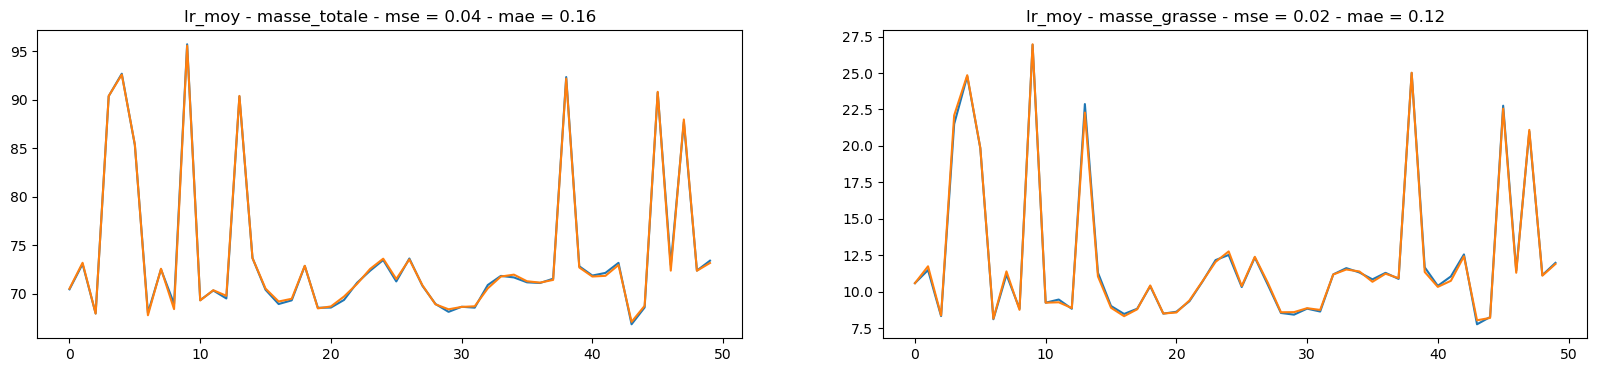

In [138]:
affiche_resultats(model_name='lr_moy', models_results=models_results_3, y_pred=y_pred, y_test=y_test)

### Bayesian Linear Regression

In [139]:
# sur Masse Totale
lrr_mt = BayesianRidge()
lrr_mt.fit(X_train.squeeze(), y_train.squeeze()[:,0])
y_pred_mt = lrr_mt.predict(X_test.squeeze())

# sur Masse Grasse
lrr_mg = BayesianRidge()
lrr_mg.fit(X_train.squeeze(), y_train.squeeze()[:,1])
y_pred_mg = lrr_mg.predict(X_test.squeeze())

# concat
y_pred = np.stack((y_pred_mt, y_pred_mg), axis=1)

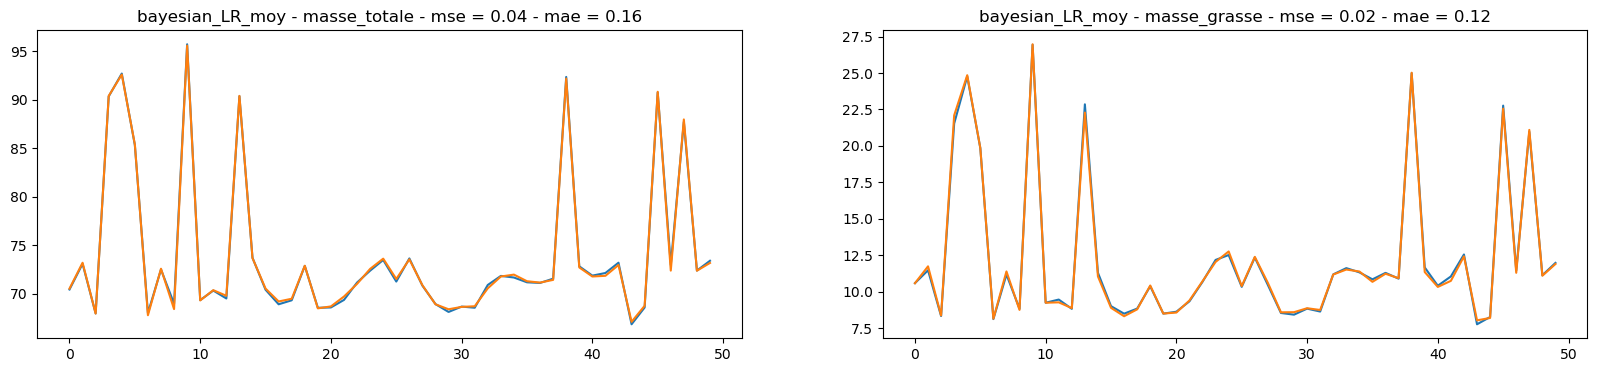

In [140]:
affiche_resultats(model_name='bayesian_LR_moy', models_results=models_results_3, y_pred=y_pred, y_test=y_test)

In [141]:
# Coefficients Bayesiens

print(f'MT : Estimated noise std dev = {np.sqrt(1/lrr_mt.alpha_)}')
print(f'MG : Estimated noise std dev = {np.sqrt(1/lrr_mg.alpha_)}')

MT : Estimated noise std dev = 0.2109273536012959
MG : Estimated noise std dev = 0.1544187653738603


In [142]:
# avec PAST jours

pprint(F'Résultats prédiction J+1 avec PAST={PAST} jours, données moyennées sur MOY={MOY} jours')
print(f'LR')
pprint(models_results_3['lr_moy'])
print(f'Bayesian LR')
pprint(models_results_3['bayesian_LR_moy'])

# écarts-types
print(f'\n')
pprint(f'Ecart type mesures Masse Totale : moyenne = {std_empiriques["Masse_Totale"].mean()}')
pprint(f'Ecart type mesures Masse Grasse : moyenne = {std_empiriques["Masse_Grasse"].mean()}')

'Résultats prédiction J+1 avec PAST=3 jours, données moyennées sur MOY=3 jours'
LR
{'masse_grasse_mae': 0.11702520271656318,
 'masse_grasse_mse': 0.02360268143344789,
 'masse_totale_mae': 0.16279984004785095,
 'masse_totale_mse': 0.04370602203296335}
Bayesian LR
{'masse_grasse_mae': 0.11775813572426853,
 'masse_grasse_mse': 0.023779408794608374,
 'masse_totale_mae': 0.1641406511179446,
 'masse_totale_mse': 0.04422387150096588}


'Ecart type mesures Masse Totale : moyenne = 0.10270092260777526'
'Ecart type mesures Masse Grasse : moyenne = 0.08626537469086287'


# Grid Search
Hyper paramètres =
- MOY = 1,3,7 : nombre de jours sur lesquels on calcule la moyenne de toutes les données
- PAST = 1,3,7,15 : nombre de jours dans le passé sur lesquels on récupère les données
- FUTURE = 1,3,7 : horizon de prédictions, avec hypothèses sur calories_food et calories_exercices

Metrics :
- MSE prédictions vs ground truth

In [100]:
### recherche PAST optimum

# mse_mt = []
# mse_mg = []

# mae_mt = []
# mae_mg = []

# list_past = range(1,20)

# mse = tf.keras.losses.MeanSquaredError()
# mae = tf.keras.losses.MeanAbsoluteError()

In [101]:
# for past in list_past:
#     obj = CreateDataset(past=past, future=1)
#     X_past, X_future, y = obj.get_dataset()
#     X = np.reshape(X_past, newshape=(X_past.shape[0],-1))
#     y = y.squeeze()
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     lr = LinearRegression()
#     lr.fit(X_train, y_train)
#     y_pred = lr.predict(X_test)
#     mse_mt.append(mse(y_pred[:,0], y_test.squeeze()[:,0]).numpy())
#     mse_mg.append(mse(y_pred[:,1], y_test.squeeze()[:,1]).numpy())
#     mae_mt.append(mae(y_pred[:,0], y_test.squeeze()[:,0]).numpy())
#     mae_mg.append(mae(y_pred[:,1], y_test.squeeze()[:,1]).numpy())

In [102]:
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,8))

# horizon = 45

# axs[0,0].plot(mse_mt[:horizon], label='MSE MT')
# axs[0,0].set_title(f'MSE sur MT vs nombre jours past')
# axs[0,0].grid(True)

# axs[0,1].plot(mae_mt[:horizon], label='MAE MT')
# axs[0,1].set_title(f'MAE sur MT vs nombre jours past')
# axs[0,1].grid(True)

# axs[1,0].plot(mse_mg[:horizon], label='MSE MG')
# axs[1,0].set_title(f'MSE sur MG vs nombre jours past')
# axs[1,0].grid(True)

# axs[1,1].plot(mae_mg[:horizon], label='MAE MG')
# axs[1,1].set_title(f'MAE sur MG vs nombre jours past')
# axs[1,1].grid(True)

# plt.show()

In [103]:
# # Valeurs optimales

# print(f'Nombre de jours past optimal pour MSE MT = {np.argmin(mse_mt)}')
# print(f'Nombre de jours past optimal pour MAE MT = {np.argmin(mae_mt)}')
# print(f'Nombre de jours past optimal pour MSE MG = {np.argmin(mse_mg)}')
# print(f'Nombre de jours past optimal pour MAE MG = {np.argmin(mae_mg)}')